<a href="https://colab.research.google.com/github/ywsyws/CUTIE/blob/main/CUTIEPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip3 install tensorflow==1.14

In [2]:
# # Mount Google Drive to Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# Import libraries
from IPython.display import Image, display
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 

import json, re, random, argparse, timeit, cv2
from os import chdir, walk, makedirs
from os.path import basename, split, join, exists
from collections import defaultdict
import unicodedata
from pprint import pprint

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [4]:
# Set root path for this project
root_path = r'/content/gdrive/MyDrive/Colab Notebooks/CUTIE/'
# Change working directory
chdir(root_path)

In [5]:
# Helper functions

def vis_bbox(data_loader, file_prefix, grid_table, gt_classes, model_output_val, file_name, bboxes, shape):
    data_input_flat = grid_table.reshape([-1])
    labels = gt_classes.reshape([-1])
    logits = model_output_val.reshape([-1, data_loader.num_classes])
    bboxes = bboxes.reshape([-1])
    
    max_len = 768*2 # upper boundary of image display size 
    img = cv2.imread(join(file_prefix, file_name))
    if img is not None:    
        shape = list(img.shape)
        
        bbox_pad = 1
        gt_color = [[255, 250, 240], [152, 245, 255], [119,204,119], [100, 149, 237], 
                    [192, 255, 62], [119,119,204], [114,124,114], [240, 128, 128], [255, 105, 180]]
        inf_color = [[255, 222, 173], [0, 255, 255], [50,219,50], [72, 61, 139], 
                     [154, 205, 50], [50,50,219], [64,76,64], [255, 0, 0], [255, 20, 147]]
        
        font_size = 0.5
        font = cv2.FONT_HERSHEY_COMPLEX
        ft_color = [50, 50, 250]
        
        factor = max_len / max(shape)
        shape[0], shape[1] = [int(s*factor) for s in shape[:2]]
        
        img = cv2.resize(img, (shape[1], shape[0]))        
        overlay_box = np.zeros(shape, dtype=img.dtype)
        overlay_line = np.zeros(shape, dtype=img.dtype)
        for i in range(len(data_input_flat)):
            if len(bboxes[i]) > 0:
                x,y,w,h = [int(p*factor) for p in bboxes[i]]
            else:
                row = i // data_loader.rows
                col = i % data_loader.cols
                x = shape[1] // data_loader.cols * col
                y = shape[0] // data_loader.rows * row
                w = shape[1] // data_loader.cols * 2
                h = shape[0] // data_loader.cols * 2
                
            if data_input_flat[i] and labels[i]:
                gt_id = labels[i]                
                cv2.rectangle(overlay_box, (x,y), (x+w,y+h), gt_color[gt_id], -1)
                    
            if max(logits[i]) > c_threshold:
                inf_id = np.argmax(logits[i])
                if inf_id:                
                    cv2.rectangle(overlay_line, (x+bbox_pad,y+bbox_pad), \
                                  (x+bbox_pad+w,y+bbox_pad+h), inf_color[inf_id], max_len//768*2)
                
            #text = data_loader.classes[gt_id] + '|' + data_loader.classes[inf_id]
            #cv2.putText(img, text, (x,y), font, font_size, ft_color)  
        
        # legends
        w = shape[1] // data_loader.cols * 4
        h = shape[0] // data_loader.cols * 2
        for i in range(1, len(data_loader.classes)):
            row = i * 3
            col = 0
            x = shape[1] // data_loader.cols * col
            y = shape[0] // data_loader.rows * row 
            cv2.rectangle(img, (x,y), (x+w,y+h), gt_color[i], -1)
            cv2.putText(img, data_loader.classes[i], (x+w,y+h), font, 0.8, ft_color)  
            
            row = i * 3 + 1
            col = 0
            x = shape[1] // data_loader.cols * col
            y = shape[0] // data_loader.rows * row 
            cv2.rectangle(img, (x+bbox_pad,y+bbox_pad), \
                          (x+bbox_pad+w,y+bbox_pad+h), inf_color[i], max_len//384)        
        
        alpha = 0.4
        cv2.addWeighted(overlay_box, alpha, img, 1-alpha, 0, img)
        cv2.addWeighted(overlay_line, 1-alpha, img, 1, 0, img)
        cv2.imwrite('results/' + file_name[:-4]+'.png', img)        
        cv2.imshow("test", img)
        cv2.waitKey(0)


def cal_accuracy(c_threshold, data_loader, grid_table, gt_classes, model_output_val, label_mapids, bbox_mapids):
    #num_tp = 0
    #num_fn = 0
    res = ''
    num_correct = 0
    num_correct_strict = 0
    num_correct_soft = 0
    num_all = grid_table.shape[0] * (model_output_val.shape[-1]-1)
    for b in range(grid_table.shape[0]):
        data_input_flat = grid_table[b,:,:,0].reshape([-1])
        labels = gt_classes[b,:,:].reshape([-1])
        logits = model_output_val[b,:,:,:].reshape(([-1, data_loader.num_classes]))
        label_mapid = label_mapids[b]
        bbox_mapid = bbox_mapids[b]
        rows, cols = grid_table.shape[1:3]
        bbox_id = np.array([row*cols+col for row in range(rows) for col in range(cols)])
        
        # ignore inputs that are not word
        indexes = np.where(data_input_flat != 0)[0]
        print(f'len(data_input_flat): {len(data_input_flat)}')
        print(f'indexes: {indexes}')
        data_selected = data_input_flat[indexes]
        labels_selected = labels[indexes]
        logits_array_selected = logits[indexes]
        bbox_id_selected = bbox_id[indexes]
        
        # calculate accuracy
        #test_classes = [1,2,3,4,5]
        #for c in test_classes:
        for c in range(1, data_loader.num_classes):
            labels_indexes = np.where(labels_selected == c)[0]
            logits_indexes = np.where(logits_array_selected[:,c] > c_threshold)[0]
            
            labels_words = list(data_loader.index_to_word[i] for i in data_selected[labels_indexes])
            logits_words = list(data_loader.index_to_word[i] for i in data_selected[logits_indexes])
            
            label_bbox_ids = label_mapid[c] # GT bbox_ids related to the type of class
            logit_bbox_ids = [bbox_mapid[bbox] for bbox in bbox_id_selected[logits_indexes] if bbox in bbox_mapid]            
            
            #if np.array_equal(labels_indexes, logits_indexes):
            if set(label_bbox_ids) == set(logit_bbox_ids): # decide as correct when all ids match
                num_correct_strict += 1  
                num_correct_soft += 1
            elif set(label_bbox_ids).issubset(set(logit_bbox_ids)): # correct when gt is subset of gt
                num_correct_soft += 1
            try: # calculate prevalence with decimal precision
                num_correct += np.shape(np.intersect1d(labels_indexes, logits_indexes))[0] / np.shape(labels_indexes)[0]
            except ZeroDivisionError:
                if np.shape(labels_indexes)[0] == 0:
                    num_correct += 1
                else:
                    num_correct += 0        
            
            # show results without the <DontCare> class                    
            if b==0:
                res += '\n{}(GT/Inf):\t"'.format(data_loader.classes[c])
                
                # ground truth label
                res += ' '.join(data_loader.index_to_word[i] for i in data_selected[labels_indexes])
                res += '" | "'
                res += ' '.join(data_loader.index_to_word[i] for i in data_selected[logits_indexes])
                res += '"'
                
                # wrong inferences results
                if not np.array_equal(labels_indexes, logits_indexes): 
                    res += '\n \t FALSES =>>'
                    logits_flat = logits_array_selected[:,c]
                    fault_logits_indexes = np.setdiff1d(logits_indexes, labels_indexes)
                    for i in range(len(data_selected)):
                        if i not in fault_logits_indexes: # only show fault_logits_indexes
                            continue
                        w = data_loader.index_to_word[data_selected[i]]
                        l = data_loader.classes[labels_selected[i]]
                        res += ' "%s"/%s, '%(w, l)
                        #res += ' "%s"/%.2f%s, '%(w, logits_flat[i], l)
                        
                #print(res)
    prevalence = num_correct / num_all
    accuracy_strict = num_correct_strict / num_all
    accuracy_soft = num_correct_soft / num_all
    return prevalence, accuracy_strict, accuracy_soft, res.encode("utf-8")

In [6]:
DEBUG = True # True to show grid as image 

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass 
    return False

class DataLoader():
    """
    grid tables producer
    """
    def __init__(self, params, update_dict=True, load_dictionary=False, data_split=0.75):
        self.random = False
        # self.data_laundry = False
        self.encoding_factor = 1 # ensures the size (rows/cols) of grid table compat with the network
        self.classes = ['O', 'TTL']
        #self.classes = ['DontCare', 'Table'] # for table
        #self.classes = ['DontCare', 'Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5'] # for column
        #self.classes = ['DontCare', 'Column']
        #self.classes = ['DontCare', 'VendorName', 'VendorTaxID', 'InvoiceDate', 'InvoiceNumber', 'ExpenseAmount', 'BaseAmount', 'TaxAmount', 'TaxRate'] # for Spanish project
        
        self.doc_path = params.doc_path
        # self.doc_test_path = params.test_path
        self.use_cutie2 = params.use_cutie2 
        # self.text_case = params.text_case 
        # self.tokenize = params.tokenize
        # if self.tokenize:
        #     self.tokenizer = tokenization.FullTokenizer('dict/vocab.txt', do_lower_case=not self.text_case)
        
        # self.rows = self.encoding_factor # to be updated 
        # self.cols = self.encoding_factor # to be updated 
        self.segment_grid = params.segment_grid if hasattr(params, 'segment_grid') else False # segment grid into two parts if grid is larger than cols_target
        # self.augment_strategy = params.augment_strategy if hasattr(params, 'augment_strategy') else 1 
        # self.pm_strategy = params.positional_mapping_strategy if hasattr(params, 'positional_mapping_strategy') else 2 
        # self.rows_segment = params.rows_segment if hasattr(params, 'rows_segment') else 72 
        # self.cols_segment = params.cols_segment if hasattr(params, 'cols_segment') else 72
        self.rows_target = params.rows_target if hasattr(params, 'rows_target') else 64 
        self.cols_target = params.cols_target if hasattr(params, 'cols_target') else 64 
        # self.rows_ulimit = params.rows_ulimit if hasattr(params, 'rows_ulimit') else 80 # handle OOM, must be multiple of self.encoding_factor
        # self.cols_ulimit = params.cols_ulimit if hasattr(params, 'cols_ulimit') else 80 # handle OOM, must be multiple of self.encoding_factor
                
        # self.fill_bbox = params.fill_bbox if hasattr(params, 'fill_bbox') else False # fill bbox with labels or use one single lable for the entire bbox
        
        # self.data_augmentation_dropout = params.data_augmentation_dropout if hasattr(params, 'data_augmentation_dropout') else False # TBD: randomly dropout rows/cols
        # self.data_augmentation_extra = params.data_augmentation_extra if hasattr(params, 'data_augmentation_extra') else False # randomly expand rows/cols
        # self.da_extra_rows = params.data_augmentation_extra_rows if hasattr(params, 'data_augmentation_extra_rows') else 0 # randomly expand rows/cols
        # self.da_extra_cols = params.data_augmentation_extra_cols if hasattr(params, 'data_augmentation_extra_cols') else 0 # randomly expand rows/cols
        
        ## 0> parameters to be tuned
        self.load_dictionary = load_dictionary # load dictionary from file rather than start from empty 
        self.dict_path = params.load_dict_from_path if load_dictionary else params.dict_path
        if self.load_dictionary:
            self.dictionary = np.load(self.dict_path + 'dictionary.npy', allow_pickle=True).item()
            self.word_to_index = np.load(self.dict_path + 'word_to_index.npy', allow_pickle=True).item()
            self.index_to_word = np.load(self.dict_path + 'index_to_word.npy', allow_pickle=True).item()
            # self.dictionary = np.load(self.dict_path + '_dictionary.npy').item()
            # self.word_to_index = np.load(self.dict_path + '_word_to_index.npy').item()
            # self.index_to_word = np.load(self.dict_path + '_index_to_word.npy').item()
        else:
            self.dictionary = {'[PAD]':0, '[UNK]':0} # word/counts. to be updated in self.load_data() and self.update_docs_dictionary()
            self.word_to_index = {}
            self.index_to_word = {}

        self.data_split = data_split # split data to training/validation, 0 for all for validation
        self.data_mode = 2 # 0 to consider key and value as two different class, 1 the same class, 2 only value considered
        # self.remove_lowfreq_words = False # remove low frequency words when set as True
        
        self.num_classes = len(self.classes)
        # self.batch_size = params.batch_size if hasattr(params, 'batch_size') else 1        
        
        # TBD: build a special cared dictionary
        self.special_dict = {'*', '='} # map texts to specific tokens        
        
        ## 1.1> load words and their location/class as training/validation docs and labels 
        self.training_doc_files = self.get_filenames(self.doc_path)
        self.training_docs, self.training_labels = self.load_data(self.training_doc_files, update_dict=update_dict) # TBD: optimize the update dict flag
        
        # polish and load dictionary/word_to_index/index_to_word as file
        self.num_words = len(self.dictionary)              
        # self.update_word_to_index()
        # self.update_docs_dictionary(self.training_docs, 3, self.remove_lowfreq_words) # remove low frequency words and add it under the <unknown> key
        
        # # save dictionary/word_to_index/index_to_word as file
        # np.save(self.dict_path + 'dictionary.npy', self.dictionary)
        # np.save(self.dict_path + 'word_to_index.npy', self.word_to_index)
        # np.save(self.dict_path + 'index_to_word.npy', self.index_to_word)
        # np.save(self.dict_path + 'classes.npy', self.classes)
        # sorted(self.dictionary.items(), key=lambda x:x[1], reverse=True)
        
        # split training / validation docs and show statistics
        num_training = int(len(self.training_docs)*self.data_split)
        data_to_be_fetched = [i for i in range(len(self.training_docs))]
        selected_training_index = data_to_be_fetched[:num_training] 
        if self.random:
            selected_training_index = random.sample(data_to_be_fetched, num_training)
        selected_validation_index = list(set(data_to_be_fetched).difference(set(selected_training_index)))
        self.validation_docs = [self.training_docs[x] for x in selected_validation_index]
        # self.training_docs = [self.training_docs[x] for x in selected_training_index]
        self.validation_labels = self.training_labels
        # print('\n\nDATASET: %d vocabularies, %d target classes'%(len(self.dictionary), len(self.classes)))
        # print('DATASET: %d for training, %d for validation'%(len(self.training_docs), len(self.validation_docs)))
        
        # ## 1.2> load test files
        # self.test_doc_files = self.get_filenames(params.test_path) if hasattr(params, 'test_path') else []
        # self.test_docs, self.test_labels = self.load_data(self.test_doc_files, update_dict=update_dict) # TBD: optimize the update dict flag
        # print('DATASET: %d for test from %s \n'%(len(self.test_docs), params.test_path if hasattr(params, 'test_path') else '_'))
        
        # self.data_shape_statistic() # show data shape static
        # if len(self.training_docs) > 0:# adapt grid table size to all training dataset docs 
        #     self.rows, self.cols, _, _ = self.cal_rows_cols(self.training_docs)  
        #     print('\nDATASHAPE: data set with maximum grid table of ({},{}), updated.\n'.format(self.rows, self.cols))    
        # else:
        #     self.rows, self.cols = self.rows_ulimit, self.cols_ulimit
                
        ## 2> call self.next_batch() outside to generate a batch of grid tables data and labels
        # self.training_data_tobe_fetched = [i for i in range(len(self.training_docs))]
        self.validation_data_tobe_fetched = [i for i in range(len(self.validation_docs))]        
        # self.test_data_tobe_fetched = [i for i in range(len(self.test_docs))]
        
    
    # def update_word_to_index(self):
    #     if self.load_dictionary:
    #         max_index = len(self.word_to_index.keys())
    #         for word in self.dictionary:
    #             if word not in self.word_to_index:
    #                 max_index += 1
    #                 self.word_to_index[word] = max_index
    #                 self.index_to_word[max_index] = word            
    #     else:   
    #         self.word_to_index = dict(list(zip(self.dictionary.keys(), list(range(self.num_words))))) 
    #         self.index_to_word = dict(list(zip(list(range(self.num_words)), self.dictionary.keys())))
    
    # def update_docs_dictionary(self, docs, lower_limit, remove_lowfreq_words):
    #     # assign docs words that appear less than @lower_limit times to word [UNK]
    #     if remove_lowfreq_words: 
    #         for doc in docs:
    #             for line in doc:
    #                 [file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
    #                     [image_w, image_h], max_row_words, max_col_words] = line 
    #                 if self.dictionary[dressed_text] < lower_limit:
    #                     line = [file_name, '[UNK]', self.word_to_index['[UNK]'], [x_left, y_top, x_right, y_bottom], \
    #                             [image_w, image_h], max_row_words, max_col_words]
    #                     self.dictionary[dressed_text] -= 1
    #                     self.dictionary['[UNK]'] += 1
    
    # def next_batch(self):
    #     batch_size = self.batch_size
        
    #     while True:
    #         if len(self.training_data_tobe_fetched) < batch_size:
    #             self.training_data_tobe_fetched = [i for i in range(len(self.training_docs))]            
    #         selected_index = random.sample(self.training_data_tobe_fetched, batch_size)
    #         self.training_data_tobe_fetched = list(set(self.training_data_tobe_fetched).difference(set(selected_index)))
    
    #         training_docs = [self.training_docs[x] for x in selected_index]
            
    #         ## data augmentation in each batch if self.data_augmentation==True
    #         rows, cols, pre_rows, pre_cols = self.cal_rows_cols(training_docs, extra_augmentation=self.data_augmentation_extra, dropout=self.data_augmentation_dropout)
    #         if self.data_augmentation_extra:
    #             print('Training grid AUGMENT size: ({},{}) from ({},{})'\
    #                   .format(rows, cols, pre_rows, pre_cols))
                
                
            
    #         grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, updated_cols, ps_indices_x, ps_indices_y = \
    #             self.positional_mapping(training_docs, self.training_labels, rows, cols)   
    #         if updated_cols > cols:
    #             print('Training grid EXPAND size: ({},{}) from ({},{})'\
    #                   .format(rows, updated_cols, rows, cols))
    #             grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, _, ps_indices_x, ps_indices_y = \
    #                 self.positional_mapping(training_docs, self.training_labels, rows, updated_cols, update_col=False)  
            
    #         ## load image and generate corresponding @ps_1dindices
    #         images, ps_1d_indices = [], []
    #         if self.use_cutie2:
    #             images, ps_1d_indices = self.positional_sampling(self.doc_path, file_names, ps_indices_x, ps_indices_y, updated_cols)   
    #             #print("image fetched {}".format(len(images)))          
    #             if len(images) == batch_size:
    #                 break
    #         else:
    #             break
        
    #     batch = {'grid_table': np.array(grid_table), 'gt_classes': np.array(gt_classes), 
    #              'data_image': np.array(images), 'ps_1d_indices': np.array(ps_1d_indices), # @images and @ps_1d_indices are only used for CUTIEv2
    #              'bboxes': bboxes, 'label_mapids': label_mapids, 'bbox_mapids': bbox_mapids,
    #              'file_name': file_names, 'shape': [rows,cols]}
    #     return batch
    
    def fetch_validation_data(self):
        batch_size = 1
        
        while True:
            if len(self.validation_data_tobe_fetched) == 0:
                self.validation_data_tobe_fetched = [i for i in range(len(self.validation_docs))]            
            selected_index = random.sample(self.validation_data_tobe_fetched, 1)
            self.validation_data_tobe_fetched = list(set(self.validation_data_tobe_fetched).difference(set(selected_index)))
    
            validation_docs = [self.validation_docs[x] for x in selected_index]
            
            ## fixed validation shape leads to better result (to be verified)
            real_rows, real_cols, _, _ = self.cal_rows_cols(validation_docs, extra_augmentation=False)
            rows = max(self.rows_target, real_rows)
            cols = max(self.rows_target, real_cols)
            
            grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, updated_cols, ps_indices_x, ps_indices_y = \
                self.positional_mapping(validation_docs, self.validation_labels, rows, cols)   
            if updated_cols > cols:
                print('Validation grid EXPAND size: ({},{}) from ({},{})'\
                      .format(rows, updated_cols, rows, cols))
                grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, _, ps_indices_x, ps_indices_y = \
                    self.positional_mapping(validation_docs, self.validation_labels, rows, updated_cols, update_col=False)     
            
            ## load image and generate corresponding @ps_1dindices
            images, ps_1d_indices = [], []
            if self.use_cutie2:
                images, ps_1d_indices = self.positional_sampling(self.doc_path, file_names, ps_indices_x, ps_indices_y, updated_cols)  
                if len(images) == batch_size:
                    break        
            else:
                break
            
        # def build_gt_pyramid(self, gt_classes):
        #     gt_classes = np.array(gt_classes)
            
        #     rate = 4 # self.pooling_factor
        #     b, h, w = np.shape(gt_classes)
        #     same_padding_left = (rate-w%rate)//2 if w%rate else 0
        #     same_padding_right = rate-(rate-w%rate)//2 if w%rate else 0
        #     same_padding_top = (rate-h%rate)//2 if h%rate else 0
        #     same_padding_bottom = rate-(rate-h%rate)//2 if h%rate else 0
        #     for gt_class in gt_classes:
        #         pad_v =  np.pad(gt_class, ((same_padding_top, same_padding_bottom), (0,0)), 'constant', constant_values=((0,0),(0,0)))
        #         pad_h =  np.pad(gt_class, ((0,0), (same_padding_left, same_padding_right)), 'constant', constant_values=((0,0),(0,0)))
                
        #         ## find mask range for each single entity
        #         num_entities = np.max(gt_classes) / self.num_classes
        #         entity_ranges = [[] for _ in range(0,num_entities)]
        #         for i in range(1, num_entities):
        #             if i % self.num_classes: # only consider non <DontCare> classes
        #                 range_y, range_x = np.where(gt_classes==i)
        #                 # entity_ranges[i] = [top, left, bottom, right, height, width]
        #                 entity_ranges[i] = [min(range_y), min(range_x), max(range_y), max(range_x), 
        #                                     max(range_y) - min(range_y), max(range_x) - min(range_x)] 
                           
                
        
        batch = {'grid_table': np.array(grid_table), 'gt_classes': np.array(gt_classes), 
                 'data_image': np.array(images), 'ps_1d_indices': np.array(ps_1d_indices), # @images and @ps_1d_indices are only used for CUTIEv2
                 'bboxes': bboxes, 'label_mapids': label_mapids, 'bbox_mapids': bbox_mapids,
                 'file_name': file_names, 'shape': [rows,cols]}
        return batch
    
    # def fetch_test_data(self): 
    #     batch_size = 1
        
    #     while True:
    #         if len(self.test_data_tobe_fetched) == 0:
    #             self.test_data_tobe_fetched = [i for i in range(len(self.test_docs))]
    #             return None
                        
    #         selected_index = self.test_data_tobe_fetched[0]
    #         self.test_data_tobe_fetched = list(set(self.test_data_tobe_fetched).difference(set([selected_index])))
    
    #         test_docs = [self.test_docs[selected_index]]
            
    #         real_rows, real_cols, _, _ = self.cal_rows_cols(test_docs, extra_augmentation=False)
    #         rows = max(self.rows_target, real_rows) # small shaped documents have better performance with shape 64
    #         cols = max(self.cols_target, real_cols) # large shaped docuemnts have better performance with shape 80
                
    #         grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, updated_cols, ps_indices_x, ps_indices_y = \
    #             self.positional_mapping(test_docs, self.test_labels, rows, cols)   
    #         if updated_cols > cols:
    #             print('Test grid EXPAND size: ({},{}) from ({},{})'\
    #                   .format(rows, updated_cols, rows, cols))
    #             grid_table, gt_classes, bboxes, label_mapids, bbox_mapids, file_names, _, ps_indices_x, ps_indices_y = \
    #                 self.positional_mapping(test_docs, self.test_labels, rows, updated_cols, update_col=False)    
                    
    #         ## load image and generate corresponding @ps_1dindices
    #         images, ps_1d_indices = [], []
    #         if self.use_cutie2:
    #             images, ps_1d_indices = self.positional_sampling(self.doc_test_path, file_names, ps_indices_x, ps_indices_y, updated_cols)          
    #             if len(images) == batch_size:
    #                 break          
    #         else:
    #             break
        
    #     batch = {'grid_table': np.array(grid_table), 'gt_classes': np.array(gt_classes), 
    #              'data_image': np.array(images), 'ps_1d_indices': np.array(ps_1d_indices), # @images and @ps_1d_indices are only used for CUTIEv2
    #              'bboxes': bboxes, 'label_mapids': label_mapids, 'bbox_mapids': bbox_mapids,
    #              'file_name': file_names, 'shape': [rows,cols]}
    #     return batch
    
    # def form_label_matrix(self, gt_classes, target_h, target_w):
    #     """
    #     build gt_classes and gt_masks with given target featuremap shape (height, width)
    #     by inspecting bboxes regions (x,y,w,h)
    #     for table / row / column identity segmentation
    #     """
    #     def has_entity_with_augmentation(entity_ranges, roi, use_jittering=False):                    
    #         ## find mask with maximum overlap
    #         max_iou = 0
    #         max_idx = None
    #         roi_t, roi_l, roi_b, roi_r = roi
    #         roi_h = roi_b - roi_t
    #         roi_w = roi_r - roi_l
    #         roi_cy = roi_t + roi_h/2
    #         roi_cx = roi_l + roi_w/2
    #         for idx, entity in enumerate(entity_ranges):
    #             if len(entity):
    #                 t, l, b, r, h, w = entity
    #                 if l>roi_l and r<roi_r and t>roi_t and b<roi_b: # overlap 1
    #                     iou = h*w / (roi_h*roi_w)
    #                 elif l<roi_l and r>roi_r and t<roi_t and b>roi_b: # overlap 2
    #                     iou = roi_h*roi_w / (h*w)
    #                 elif l>roi_r or t>roi_b or b<roi_t or r<roi_l: # no intersection
    #                     continue
    #                 else:
    #                     iou = min(h*w, roi_h*roi_w) / max(h*w, roi_h*roi_w)
                        
    #                 # TBD: add jittering augmentation method  
    #                 if use_jittering:
    #                     pass                          
    #                 if iou > max_iou:
    #                     max_idx = idx
    #                     max_iou = iou
                        
    #         ## check centrality / containment / uniqueness
    #         t, l, b, r, h, w = entity[idx]
    #         cy = t + h/2
    #         cx = l + w/2
    #         if roi_t+h/3 < cy and cy < toi_b-h/3 and roi_l+w/3 < cx and cx < roi_r-w/3: # centrality
    #             if (w > h and roi_w > w*0.9) or (w < h and roi_h > h*0.9): # containment
    #                 if True: # uniqueness is already checked with maixmum IOU
    #                     return True
    #         return False                 
    
    #     shape = gt_classes.shape
    #     rate_v = shape[0] / target_h
    #     rate_h = shape[1] / target_w
    #     dst_classes = [[[] for i in range(target_h)] for j in range(target_w)]
    #     dst_masks = [[[] for i in range(target_h)] for j in range(target_w)]
    #     for i in range(target_h):
    #         for j in range(target_w):
    #             roi = [rate_h*j, rate_v*i, rate_h*(j+1), rate_v*(i+1)] # [top, left, bottom, right]
                
    #             dst_classes[i][j] = has_entity_with_augmentation(entity_ranges, roi, False)
                
    #             mask = gt_classes[roi[1]:roi[3], roi[0]:roi[2]]
    #             dst_masks[i][j] = mask if dst_classes[i][j] else np.zeros(np.shape(mask))
        
    #     return np.array(dst_classes), np.array(dst_masks)
        
    def data_shape_statistic(self):        
        def shape_statistic(docs):
            res_all = defaultdict(int)
            res_row = defaultdict(int)
            res_col = defaultdict(int)
            for doc in docs:
                rows, cols, _, _ = self.cal_rows_cols([doc])
                res_all[rows] += 1
                res_all[cols] += 1
                res_row[rows] += 1
                res_col[cols] += 1
            res_all = sorted(res_all.items(), key=lambda x:x[0], reverse=True)
            res_row = sorted(res_row.items(), key=lambda x:x[0], reverse=True)
            res_col = sorted(res_col.items(), key=lambda x:x[0], reverse=True)
            return res_all, res_row, res_col
    
        tss, tss_r, tss_c = shape_statistic(self.training_docs) # training shape static
        vss, vss_r, vss_c = shape_statistic(self.validation_docs)
        tess, tess_r, tess_c = shape_statistic(self.test_docs)
        print("Training statistic: ", tss)
        print("\t num: ", len(self.training_docs))
        print("\t rows statistic: ", tss_r)
        print("\t cols statistic: ", tss_c)
        print("\nValidation statistic: ", vss)
        print("\t num: ", len(self.validation_docs))
        print("\t rows statistic: ", vss_r)
        print("\t cols statistic: ", vss_c)
        print("\nTest statistic: ", tess)
        print("\t num: ", len(self.test_docs))
        print("\t rows statistic: ", tess_r)
        print("\t cols statistic: ", tess_c)
        
        ## remove data samples not matching the training principle
        def data_laundry(docs):
            idx = 0
            while idx < len(docs):
                rows, cols, _, _ = self.cal_rows_cols([docs[idx]])
                if rows > self.rows_ulimit or cols > self.cols_ulimit:
                    del docs[idx]
                else:
                    idx += 1
        if self.data_laundry:
            print("\nRemoving grids with shape larger than ({},{}).".format(self.rows_ulimit, self.cols_ulimit))
            data_laundry(self.training_docs)
            data_laundry(self.validation_docs)
            data_laundry(self.training_docs)
        
            tss, tss_r, tss_c = shape_statistic(self.training_docs) # training shape static
            vss, vss_r, vss_c = shape_statistic(self.validation_docs)
            tess, tess_r, tess_c = shape_statistic(self.test_docs)
            print("Training statistic after laundary: ", tss)
            print("\t num: ", len(self.training_docs))
            print("\t rows statistic: ", tss_r)
            print("\t cols statistic: ", tss_c)
            print("Validation statistic after laundary: ", vss)
            print("\t num: ", len(self.validation_docs))
            print("\t rows statistic: ", vss_r)
            print("\t cols statistic: ", vss_c)
            print("Test statistic after laundary: ", tess)
            print("\t num: ", len(self.test_docs))
            print("\t rows statistic: ", tess_r)
            print("\t cols statistic: ", tess_c)
    
    def positional_mapping(self, docs, labels, rows, cols):
        """
        docs in format:
        [[file_name, text, word_id, [x_left, y_top, x_right, y_bottom], [left, top, right, bottom], max_row_words, max_col_words] ]
        return grid_tables, gird_labels, dict bboxes {file_name:[]}, file_names
        """
        grid_tables = []
        gird_labels = []
        ps_indices_x = [] # positional sampling indices
        ps_indices_y = [] # positional sampling indices
        bboxes = {}
        label_mapids = []
        bbox_mapids = [] # [{}, ] bbox identifier, each id with one or multiple bbox/bboxes
        file_names = []
        for doc in docs:
            items = []
            cols_e = 2 * cols # use @cols_e larger than required @cols as buffer
            grid_table = np.zeros([rows, cols_e], dtype=np.int32)
            grid_label = np.zeros([rows, cols_e], dtype=np.int8)
            ps_x = np.zeros([rows, cols_e], dtype=np.int32)
            ps_y = np.zeros([rows, cols_e], dtype=np.int32)
            bbox = [[] for c in range(cols_e) for r in range(rows)]
            bbox_id, bbox_mapid = 0, {} # one word in one or many positions in a bbox is mapped in bbox_mapid
            label_mapid = [[] for _ in range(self.num_classes)] # each class is connected to several bboxes (words)
            drawing_board = np.zeros([rows, cols_e], dtype=str)
            for item in doc:
                file_name = item[0]
                text = item[1]
                word_id = item[2]
                x_left, y_top, x_right, y_bottom = item[3][:]
                left, top, right, bottom = item[4][:]
                
                dict_id = self.word_to_index[text]                
                entity_id, class_id = self.dress_class(file_name, word_id, labels)
                
                bbox_id += 1
#                 if self.fill_bbox: # TBD: overlap avoidance
#                     top = int(rows * y_top / image_h)
#                     bottom = int(rows * y_bottom / image_h)
#                     left = int(cols * x_left / image_w)
#                     right = int(cols * x_right / image_w)
#                     grid_table[top:bottom, left:right] = dict_id  
#                     grid_label[top:bottom, left:right] = class_id  
#                      
#                     label_mapid[class_id].append(bbox_id)
#                     for row in range(top, bottom):
#                         for col in range(left, right):
#                             bbox_mapid[row*cols+col] = bbox_id
#                      
#                     for y in range(top, bottom):
#                         for x in range(left, right):
#                             bbox[y][x] = [x_left, y_top, x_right-x_left, y_bottom-y_top]
                label_mapid[class_id].append(bbox_id)    
                
                #v_c = (y_top - top + (y_bottom-y_top)/2) / (bottom-top)
                #h_c = (x_left - left + (x_right-x_left)/2) / (right-left)
                #v_c = (y_top + (y_bottom-y_top)/2) / bottom
                #h_c = (x_left + (x_right-x_left)/2) / right 
                #v_c = (y_top-top) / (bottom-top)
                #h_c = (x_left-left) / (right-left)
                #v_c = (y_top) / (bottom)
                #h_c = (x_left) / (right)
                box_y = y_top + (y_bottom-y_top)/2
                box_x = x_left # h_l is used for image feature map positional sampling
                v_c = (y_top - top + (y_bottom-y_top)/2) / (bottom-top)
                h_c = (x_left - left + (x_right-x_left)/2) / (right-left) # h_c is used for sorting items
                row = int(rows * v_c) 
                col = int(cols * h_c) 
                items.append([row, col, [box_y, box_x], [v_c, h_c], file_name, dict_id, class_id, entity_id, bbox_id, [x_left, y_top, x_right-x_left, y_bottom-y_top]])                       
            
            items.sort(key=lambda x: (x[0], x[3], x[5])) # sort according to row > h_c > bbox_id
            for item in items:
                row, col, [box_y, box_x], [v_c, h_c], file_name, dict_id, class_id, entity_id, bbox_id, box = item
                entity_class_id = entity_id*self.num_classes + class_id
                
                while col < cols and grid_table[row, col] != 0:
                    col += 1            
                
                ptr = 0
                if col == cols: # shift to find slot to drop the current item
                    col -= 1
                    while ptr<cols and grid_table[row, ptr] != 0:
                        ptr += 1
                    if ptr == cols:
                        grid_table[row, :-1] = grid_table[row, 1:]
                    else:
                        grid_table[row, ptr:-1] = grid_table[row, ptr+1:]
                
                grid_table[row, col] = dict_id
                grid_label[row, col] = entity_class_id
                ps_x[row, col] = box_x
                ps_y[row, col] = box_y
                bbox_mapid[row*cols+col] = bbox_id     
                bbox[row*cols+col] = box
                
                # # self.pm_strategy 0: skip if overlap
                # # self.pm_strategy 1: shift to find slot if overlap
                # # self.pm_strategy 2: expand grid table if overlap
                # if self.pm_strategy == 0:
                #     if col == cols:                     
                #         print('overlap in {} row {} r{}c{}!'.
                #               format(file_name, row, rows, cols))
                #         #print(grid_table[row,:])
                #         #print('overlap in {} <{}> row {} r{}c{}!'.
                #         #      format(file_name, self.index_to_word[dict_id], row, rows, cols))
                #     else:
                #         grid_table[row, col] = dict_id
                #         grid_label[row, col] = entity_class_id                       
                #         bbox_mapid[row*cols+col] = bbox_id                       
                #         bbox[row*cols+col] = box   
                # elif self.pm_strategy==1 or self.pm_strategy==2:
                #     ptr = 0
                #     if col == cols: # shift to find slot to drop the current item
                #         col -= 1
                #         while ptr<cols and grid_table[row, ptr] != 0:
                #             ptr += 1
                #         if ptr == cols:
                #             grid_table[row, :-1] = grid_table[row, 1:]
                #         else:
                #             grid_table[row, ptr:-1] = grid_table[row, ptr+1:]
                        
                #     if self.pm_strategy == 2:
                #         while col < cols_e and grid_table[row, col] != 0:
                #             col += 1
                #         if col > cols: # update maximum cols in current grid
                #             print(grid_table[row,:col])
                #             print('overlap in {} <{}> row {} r{}c{}!'.
                #                   format(file_name, self.index_to_word[dict_id], row, rows, cols))
                #             cols = col
                #         if col == cols_e:      
                #             print('overlap!')
                    
                #     grid_table[row, col] = dict_id
                #     grid_label[row, col] = entity_class_id
                #     ps_x[row, col] = box_x
                #     ps_y[row, col] = box_y
                #     bbox_mapid[row*cols+col] = bbox_id     
                #     bbox[row*cols+col] = box
                
            cols = self.fit_shape(cols)
            grid_table = grid_table[..., :cols]
            grid_label = grid_label[..., :cols]
            ps_x = np.array(ps_x[..., :cols])
            ps_y = np.array(ps_y[..., :cols])
            
            if DEBUG:
                self.grid_visualization(file_name, grid_table, grid_label)
            
            grid_tables.append(np.expand_dims(grid_table, -1)) 
            gird_labels.append(grid_label) 
            ps_indices_x.append(ps_x)
            ps_indices_y.append(ps_y)
            bboxes[file_name] = bbox
            label_mapids.append(label_mapid)
            bbox_mapids.append(bbox_mapid)
            file_names.append(file_name)
            
        return grid_tables, gird_labels, bboxes, label_mapids, bbox_mapids, file_names, cols, ps_indices_x, ps_indices_y
    
    def positional_sampling(self, path, file_names, ps_indices_x, ps_indices_y, updated_cols):
        images, ps_1d_indices = [], []
        
        ## load image and generate corresponding @ps_1dindices
        max_h, max_w = 0, updated_cols
        for i in range(len(file_names)):
            file_name = file_names[i]
            file_path = join(path, file_name) # TBD: ensure image is upright
            ps_1d_x = np.array(ps_indices_x[i], dtype=np.float32).reshape([-1])
            ps_1d_y = np.array(ps_indices_y[i], dtype=np.float32).reshape([-1])
            
            image = cv2.imread(file_path)
            if image is not None:
                h, w, _ = image.shape # [h,w,c]
                factor = max_w / w
                
                h = int(h*factor)
                ps_1d_x *= factor # TBD: implement more accurate mapping method rather than nearest neighbor, since the .4 or .6 leads to two different sampling results
                ps_1d_y *= factor                
                
                ps_1d = np.int32(np.floor(ps_1d_x) + np.floor(ps_1d_y) * max_w)
                max_items = max_w * h - 1
                for i in range(len(ps_1d)):
                    if ps_1d[i] > max_items - 1:
                        ps_1d[i] = max_items - 1
                    
                
                image = cv2.resize(image, (max_w, h))
                image = (image-127.5) / 255
            else:
                #print('Warning: {} image not found!'.format(file_path))
                print('{} ignored due to image file not found.'.format(file_path))
                image, ps_1d = None, None
                break
                
            if image is not None and ps_1d is not None: # ignore data with no images                 
                ps_1d_indices.append(ps_1d)
                images.append(image)
                h,w,c = image.shape
                if h > max_h:
                    max_h = h
            else:
                pass
                #print('{} ignored due to image file not found.'.format(file_path))
                
        ## pad image to the same shape
        for i,image in enumerate(images): 
            pad_img = np.zeros([max_h, max_w, 3], dtype=image.dtype)
            pad_img[:image.shape[0], :, :] = image
            images[i] = pad_img
        
        return images, ps_1d_indices
    
    def load_data(self, data_files, update_dict=False):
        """
        label_dressed in format:
        {file_id: {class: [{'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''}, ] } }
        load doc words with location and class returned in format: 
        [[file_name, text, word_id, [x_left, y_top, x_right, y_bottom], [left, top, right, bottom], max_row_words, max_col_words] ]
        """
        label_dressed = {}
        doc_dressed = []
        if not data_files:
            print("no data file found.")        
        for file in data_files:
            with open(file, encoding='utf-8') as f:
                data = json.load(f)
                file_id = data['global_attributes']['file_id']
                
                label = self.collect_label(file_id, data['fileds'])
                # ignore corrupted data
                if not label:
                    continue                
                label_dressed.update(label) 
                
                data = self.collect_data(file_id, data['text_boxes'], update_dict)
                for i in data:
                    doc_dressed.append(i)
                    
        return doc_dressed, label_dressed       
    
    def cal_rows_cols(self, docs, extra_augmentation=False, dropout=False):                  
        max_row = self.encoding_factor
        max_col = self.encoding_factor
        for doc in docs:
            for line in doc: 
                _, _, _, _, _, max_row_words, max_col_words = line
                if max_row_words > max_row:
                    max_row = max_row_words
                if max_col_words > max_col:
                    max_col = max_col_words
        
        pre_rows = self.fit_shape(max_row) #(max_row//self.encoding_factor+1) * self.encoding_factor
        pre_cols = self.fit_shape(max_col) #(max_col//self.encoding_factor+1) * self.encoding_factor
        
        rows, cols = 0, 0
        if extra_augmentation:
            pad_row = int(random.gauss(0, self.da_extra_rows*self.encoding_factor)) #abs(random.gauss(0, u))
            pad_col = int(random.gauss(0, self.da_extra_cols*self.encoding_factor)) #random.randint(0, u)
            
            if self.augment_strategy == 1: # strategy 1: augment data by increasing grid shape sizes
                pad_row = abs(pad_row)
                pad_col = abs(pad_col)
                rows = self.fit_shape(max_row+pad_row) # apply upper boundary to avoid OOM
                cols = self.fit_shape(max_col+pad_col) # apply upper boundary to avoid OOM
            elif self.augment_strategy == 2 or self.augment_strategy == 3: # strategy 2: augment by increasing or decreasing the target gird shape size
                rows = self.fit_shape(max(self.rows_target+pad_row, max_row)) # protect grid shape
                cols = self.fit_shape(max(self.cols_target+pad_col, max_col)) # protect grid shape
            else:
                raise Exception('unknown augment strategy')
            rows = min(rows, self.rows_ulimit) # apply upper boundary to avoid OOM
            cols = min(cols, self.cols_ulimit) # apply upper boundary to avoid OOM                                
        else:
            rows = pre_rows
            cols = pre_cols
        return rows, cols, pre_rows, pre_cols 
    
    def fit_shape(self, shape): # modify shape size to fit the encoding factor
        while shape % self.encoding_factor:
            shape += 1
        return shape
    
    def expand_shape(self, shape): # expand shape size with step 2
        return self.fit_shape(shape+1)
        
    def collect_data(self, file_name, content, update_dict):
        """
        dress and preserve only interested data.
        """          
        content_dressed = []
        left, top, right, bottom, buffer = 9999, 9999, 0, 0, 2
        for line in content:
            bbox = line['bbox'] # handle data corrupt
            if len(bbox) == 0:
                continue
            if line['text'] in self.special_dict: # ignore potential overlap causing characters
                continue
            
            x_left, y_top, x_right, y_bottom = self.dress_bbox(bbox)        
            # TBD: the real image size is better for calculating the relative x/y/w/h
            if x_left < left: left = x_left - buffer
            if y_top < top: top = y_top - buffer
            if x_right > right: right = x_right + buffer
            if y_bottom > bottom: bottom = y_bottom + buffer
            
            word_id = line['word_id']
            dressed_texts = self.dress_text(line['text'], update_dict)
            
            num_block = len(dressed_texts)
            for i, dressed_text in enumerate(dressed_texts): # handling tokenized text, separate bbox
                new_left = int(x_left + (x_right-x_left) / num_block * (i))
                new_right = int(x_left + (x_right-x_left) / num_block * (i+1))
                content_dressed.append([file_name, dressed_text, word_id, [new_left, y_top, new_right, y_bottom]])
            
        # initial calculation of maximum number of words in rows/cols in terms of image size
        num_words_row = [0 for _ in range(bottom)] # number of words in each row
        num_words_col = [0 for _ in range(right)] # number of words in each column
        for line in content_dressed:
            _, _, _, [x_left, y_top, x_right, y_bottom] = line
            for y in range(y_top, y_bottom):
                num_words_row[y] += 1
            for x in range(x_left, x_right):
                num_words_col[x] += 1
        max_row_words = self.fit_shape(max(num_words_row))
        max_col_words = 0#self.fit_shape(max(num_words_col))
        
        # further expansion of maximum number of words in rows/cols in terms of grid shape
        max_rows = max(self.encoding_factor, max_row_words)
        max_cols = max(self.encoding_factor, max_col_words)
        DONE = False
        while not DONE:
            DONE = True
            grid_table = np.zeros([max_rows, max_cols], dtype=np.int32)
            for line in content_dressed:
                _, _, _, [x_left, y_top, x_right, y_bottom] = line
                row = int(max_rows * (y_top - top + (y_bottom-y_top)/2) / (bottom-top))
                col = int(max_cols * (x_left - left + (x_right-x_left)/2) / (right-left))
                #row = int(max_rows * (y_top + (y_bottom-y_top)/2) / (bottom))
                #col = int(max_cols * (x_left + (x_right-x_left)/2) / (right))
                #row = int(max_rows * (y_top-top) / (bottom-top))
                #col = int(max_cols * (x_left-left) / (right-left))
                #row = int(max_rows * (y_top) / (bottom))
                #col = int(max_cols * (x_left) / (right))
                #row = int(max_rows * (y_top + (y_bottom-y_top)/2) / bottom)  
                #col = int(max_cols * (x_left + (x_right-x_left)/2) / right) 
                
                while col < max_cols and grid_table[row, col] != 0: # shift to find slot to drop the current item
                    col += 1
                if col == max_cols: # shift to find slot to drop the current item
                    col -= 1
                    ptr = 0
                    while ptr<max_cols and grid_table[row, ptr] != 0:
                        ptr += 1
                    if ptr == max_cols: # overlap cannot be solved in current row, then expand the grid
                        max_cols = self.expand_shape(max_cols)
                        DONE = False
                        break
                    
                    grid_table[row, ptr:-1] = grid_table[row, ptr+1:]
                
                if DONE:
                    if row > max_rows or col>max_cols:
                        print('wrong')
                    grid_table[row, col] = 1
        
        max_rows = self.fit_shape(max_rows)
        max_cols = self.fit_shape(max_cols)
        
        #print('{} collected in shape: {},{}'.format(file_name, max_rows, max_cols))
        
        # segment grid into two parts if number of cols is larger than self.cols_target
        data = []
        if self.segment_grid and max_cols > self.cols_segment:
            content_dressed_left = []
            content_dressed_right = []
            cnt = defaultdict(int) # counter for number of words in a specific row
            cnt_l, cnt_r = defaultdict(int), defaultdict(int) # update max_cols if larger than self.cols_segment
            left_boundary = max_cols - self.cols_segment
            right_boundary = self.cols_segment
            for i, line in enumerate(content_dressed):
                file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom] = line
                
                row = int(max_rows * (y_top + (y_bottom-y_top)/2) / bottom)
                cnt[row] += 1                
                if cnt[row] <= left_boundary:
                    cnt_l[row] += 1
                    content_dressed_left.append([file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                                      [left, top, right, bottom], max_rows, self.cols_segment])
                elif left_boundary < cnt[row] <= right_boundary:
                    cnt_l[row] += 1
                    cnt_r[row] += 1
                    content_dressed_left.append([file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                                      [left, top, right, bottom], max_rows, self.cols_segment])
                    content_dressed_right.append([file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                                      [left, top, right, bottom], max_rows, max(max(cnt_r.values()), self.cols_segment)])
                else:
                    cnt_r[row] += 1
                    content_dressed_right.append([file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                                      [left, top, right, bottom], max_rows, max(max(cnt_r.values()), self.cols_segment)])
            #print(sorted(cnt.items(), key=lambda x:x[1], reverse=True))
            #print(sorted(cnt_l.items(), key=lambda x:x[1], reverse=True))
            #print(sorted(cnt_r.items(), key=lambda x:x[1], reverse=True))
            if max(cnt_l.values()) < 2*self.cols_segment:
                data.append(content_dressed_left)
            if max(cnt_r.values()) < 2*self.cols_segment: # avoid OOM, which tends to happen in the right side
                data.append(content_dressed_right)
        else:
            for i, line in enumerate(content_dressed): # append height/width/numofwords to the list
                file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom] = line
                content_dressed[i] = [file_name, dressed_text, word_id, [x_left, y_top, x_right, y_bottom], \
                                      [left, top, right, bottom], max_rows, max_cols ]
            data.append(content_dressed)
        return data
    
    def collect_label(self, file_id, content):
        """
        dress and preserve only interested data.
        label_dressed in format:
        {file_id: {class: [{'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''}, ] } }
        """
        label_dressed = dict()
        label_dressed[file_id] = {cls:[] for cls in self.classes[1:]}
        for line in content:
            cls = line['field_name']
            if cls in self.classes:
                #identity = line.get('identity', 0) 
                label_dressed[file_id][cls].append( {'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''} )
                label_dressed[file_id][cls][-1]['key_id'] = line.get('key_id', [])
                label_dressed[file_id][cls][-1]['value_id'] = line['value_id'] # value_id
                label_dressed[file_id][cls][-1]['key_text'] = line.get('key_text', []) 
                label_dressed[file_id][cls][-1]['value_text'] = line['value_text'] # value_text
                
        # handle corrupted data
        for cls in label_dressed[file_id]: 
            for idx, label in enumerate(label_dressed[file_id][cls]):
                if len(label) == 0: # no relevant class in sample @file_id
                    continue
                if (len(label['key_text'])>0 and len(label['key_id'])==0) or \
                   (len(label['value_text'])>0 and len(label['value_id'])==0):
                    return None
            
        return label_dressed

    def dress_class(self, file_name, word_id, labels):
        """
        label_dressed in format:
        {file_id: {class: [{'key_id':[], 'value_id':[], 'key_text':'', 'value_text':''}, ] } }
        """
        if file_name in labels:
            for cls, cls_labels in labels[file_name].items():
                for idx, cls_label in enumerate(cls_labels):
                    for key, values in cls_label.items():
                        if (key=='key_id' or key=='value_id') and word_id in values:
                            if key == 'key_id':
                                if self.data_mode == 0:
                                    return idx, self.classes.index(cls) * 2 - 1 # odd
                                elif self.data_mode == 1:
                                    return idx, self.classes.index(cls)
                                else: # ignore key_id when self.data_mode is not 0 or 1
                                    return 0, 0
                            elif key == 'value_id':
                                if self.data_mode == 0:
                                    return idx, self.classes.index(cls) * 2 # even 
                                else: # when self.data_mode is 1 or 2
                                    return idx, self.classes.index(cls) 
            return 0, 0 # 0 is of class type 'DontCare'
        print("No matched labels found for {}".format(file_name))
    
    def dress_text(self, text, update_dict):
        """
        three cases covered: 
        alphabetic string, numeric string, special character
        """
        string = text.lower()
        for i, c in enumerate(string):
            if is_number(c):
                string = string[:i] + '0' + string[i+1:]
                
        strings = [string]
        # if self.tokenize:
        #     strings = self.tokenizer.tokenize(strings[0])
        #     #print(string, '-->', strings)
            
        for idx, string in enumerate(strings):            
            if string.isalpha():
                if string in self.special_dict:
                    string = self.special_dict[string]
                # TBD: convert a word to its most similar word in a known vocabulary
            elif is_number(string):
                pass
            elif len(string)==1: # special character
                pass
            else:
                # TBD: seperate string as parts for alpha and number combinated strings
                #string = re.findall('[a-z]+', string)
                pass            
            
            if string not in self.dictionary.keys():
                if update_dict:
                    self.dictionary[string] = 0
                else:
                    #print('unknown text: ' + string)
                    string = '[UNK]' # TBD: take special care to unmet words\
            self.dictionary[string] += 1
            
            strings[idx] = string
        return strings
            
    def dress_bbox(self, bbox):
        positions = np.array(bbox).reshape([-1])
        x_left = max(0, min(positions[0::2]))
        x_right = max(positions[0::2])
        y_top = max(0, min(positions[1::2]))
        y_bottom = max(positions[1::2])
        w = x_right - x_left
        h = y_bottom - y_top
        return int(x_left), int(y_top), int(x_right), int(y_bottom)       
    
    def get_filenames(self, data_path):
        files = []
        for dirpath,dirnames,filenames in walk(data_path):
            for filename in filenames:
                file = join(dirpath,filename)
                if file.endswith('csv') or file.endswith('json'):
                    files.append(file)
        return files       
            
    def grid_visualization(self, file_name, grid, label):
        from google.colab.patches import cv2_imshow
        height, width = np.shape(grid)
        grid_box_h, grid_box_w = 20, 40
        palette = np.zeros([height*grid_box_h, width*grid_box_w, 3], np.uint8)
        font = cv2.FONT_HERSHEY_SIMPLEX
        gt_color = [[255, 250, 240], [152, 245, 255], [127, 255, 212], [100, 149, 237], 
                    [192, 255, 62], [175, 238, 238], [255, 130, 171], [240, 128, 128], [255, 105, 180]]
        cv2.putText(palette, file_name+"({},{})".format(height,width), (grid_box_h,grid_box_w), font, 0.6, [255,0,0])  
        for h in range(height):
            cv2.line(palette, (0,h*grid_box_h), (width*grid_box_w, h*grid_box_h), (100,100,100))
            for w in range(width):
                if grid[h,w]:
                    org = (int((w+1)*grid_box_w*0.7),int((h+1)*grid_box_h*0.9))
                    color = gt_color[label[h,w]]
                    cv2.putText(palette, self.index_to_word[grid[h,w]], org, font, 0.4, color)        
        
        img = cv2.imread(self.doc_path+'/'+file_name)
        if img is not None:
            shape = list(img.shape)
            max_len = 768
            factor = max_len / max(shape)
            shape[0], shape[1] = [int(s*factor) for s in shape[:2]]
            img = cv2.resize(img, (shape[1], shape[0]))  
            cv2.imshow("img", img)
        cv2_imshow(palette)
        cv2.waitKey(0)

# 1. Model

In [7]:
def layer(op):
    def layer_decorated(self, *args, **kwargs):
        name = kwargs.setdefault('name', self.get_unique_name(op.__name__))        
        if len(self.layer_inputs) == 0:
            raise RuntimeError('No input variables found for layers %s' % name)
        elif len(self.layer_inputs) == 1:
            layer_input = self.layer_inputs[0]
        else:
            layer_input = list(self.layer_inputs)            
            
        layer_output = op(self, layer_input, *args, **kwargs)
        
        self.layers[name] = layer_output
        self.feed(layer_output)
        
        return self
    return layer_decorated
    
    
class Model(object):
    def __init__(self, trainable=True):
        self.layers = dict()      
        self.trainable = trainable
        
        self.layer_inputs = []        
        self.setup()
    
    
    def build_loss(self):
        raise NotImplementedError('Must be subclassed.')
    
    
    def setup(self):        
        raise NotImplementedError('Must be subclassed.')
     
    
    @layer
    def embed(self, layer_input, vocabulary_size, embedding_size, name, dropout=1, trainable=True):
        with tf.compat.v1.variable_scope(name) as scope:
            init_embedding = tf.random_uniform_initializer(-1.0, 1.0)
            embeddings = self.make_var('weights', [vocabulary_size, embedding_size], init_embedding, None, trainable)
            shape = tf.shape(layer_input)
            
            reshaped_input = tf.reshape(layer_input, [-1])
            e = tf.nn.embedding_lookup(embeddings, reshaped_input)
            e = tf.nn.dropout(e, dropout)
            reshaped_e = tf.reshape(e, [shape[0], shape[1], shape[2], embedding_size])
            return reshaped_e
    
    
    # @layer
    # def bert_embed(self, layer_input, vocab_size, embedding_size=768, use_one_hot_embeddings=False, 
    #                initializer_range=0.02, name="embeddings", trainable=False):
    #     with tf.compat.v1.variable_scope("bert"):
    #       with tf.compat.v1.variable_scope("embeddings"):
    #         # Perform embedding lookup on the word ids.
    #         (embedding_output, embedding_table) = self.embedding_lookup(
    #             input_ids=layer_input, vocab_size=vocab_size, embedding_size=embedding_size,
    #             initializer_range=initializer_range,
    #             word_embedding_name="word_embeddings",
    #             use_one_hot_embeddings=use_one_hot_embeddings,
    #             trainable=trainable)
    #         self.embedding_table = embedding_table # the inherited class need a self.embedding_table variable
    #         return embedding_output        
        
    
    # @layer
    # def positional_sampling(self, layer_input, feature_dimension, name='positional_sampling'):
    #     featuremap = layer_input[0]
    #     batch_indices = layer_input[1]
    #     grid = layer_input[2]        
        
    #     shape_grid = tf.shape(grid)
        
    #     featuremap_flat = tf.reshape(featuremap, [shape_grid[0], -1, feature_dimension])        
    #     batch_indices_flat = tf.reshape(batch_indices, [shape_grid[0], -1])        
    #     batch_ps_flat = tf.batch_gather(featuremap_flat, batch_indices_flat)
        
    #     b, h, w, c = shape_grid[0], shape_grid[1], shape_grid[2], feature_dimension
    #     return tf.reshape(batch_ps_flat, [b,h,w,c])
    
    
    # @layer
    # def sepconv(self, layer_input, k_h, k_w, cardinality, compression, name, activation='relu', trainable=True):
    #     """ customized seperable convolution
    #     """
    #     convolve = lambda input, filter: tf.nn.conv2d(input, filter, [1,1,1,1], 'SAME')
    #     activate = lambda z: tf.nn.relu(z, 'relu')
    #     with tf.compat.v1.variable_scope(name) as scope:
    #         init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
    #         init_biases = tf.constant_initializer(0.0)
    #         regularizer = self.l2_regularizer(self.weight_decay)
    #         c_i = layer_input.get_shape().as_list()[-1]
            
    #         layer_output = []
    #         c = c_i / cardinality / compression
    #         for _ in range(cardinality):
    #             a = self.convolution(convolve, activate, layer_input, 1, 1, c_i, c,
    #                                  init_weights, init_biases, regularizer, trainable, '0_{}'.format(_))                
    #             a = self.convolution(convolve, activate, a, k_h, k_w, c, c, 
    #                                  init_weights, init_biases, regularizer, trainable, '1_{}'.format(_))
    #             a = self.convolution(convolve, activate, a, 1, 1, c, c_i, 
    #                                  init_weights, init_biases, regularizer, trainable, '2_{}'.format(_))
    #             layer_output.append(a)
    #         layer_output = tf.add_n(layer_output)
    #         return tf.add(layer_output, layer_input)
        
    
    # @layer
    # def up_sepconv(self, layer_input, k_h, k_w, cardinality, compression, name, activation='relu', trainable=True):
    #     """ customized upscale seperable convolution
    #     """
    #     convolve = lambda input, filter: tf.nn.conv2d(input, filter, [1,1,1,1], 'SAME')
    #     activate = lambda z: tf.nn.relu(z, 'relu')        
    #     with tf.compat.v1.variable_scope(name) as scope:
    #         shape = tf.shape(layer_input)
    #         h = shape[1]
    #         w = shape[2]
    #         layer_input = tf.image.resize_nearest_neighbor(layer_input, [2*h, 2*w])
    #         init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
    #         init_biases = tf.constant_initializer(0.0)
    #         regularizer = self.l2_regularizer(self.weight_decay)
    #         c_i = layer_input.get_shape().as_list()[-1]
            
    #         layer_output = []
    #         c = c_i / cardinality / compression
    #         for _ in range(cardinality):
    #             a = self.convolution(convolve, activate, layer_input, 1, 1, c_i, c,
    #                                  init_weights, init_biases, regularizer, trainable, '0_{}'.format(_))                
    #             a = self.convolution(convolve, activate, a, k_h, k_w, c, c, 
    #                                  init_weights, init_biases, regularizer, trainable, '1_{}'.format(_))
    #             a = self.convolution(convolve, activate, a, 1, 1, c, c_i, 
    #                                  init_weights, init_biases, regularizer, trainable, '2_{}'.format(_))
    #             layer_output.append(a)
    #         layer_output = tf.add_n(layer_output)
    #         return tf.add(layer_output, layer_input)
        
        
    # @layer
    # def dense_block(self, layer_input, k_h, k_w, c_o, depth, name, activation='relu', trainable=True):
    #     convolve = lambda input, filter: tf.nn.conv2d(input, filter, [1,1,1,1], 'SAME')
    #     activate = lambda z: tf.nn.relu(z, 'relu')
    #     with tf.compat.v1.variable_scope(name) as scope:
    #         init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
    #         init_biases = tf.constant_initializer(0.0)
    #         regularizer = self.l2_regularizer(self.weight_decay)  
            
    #         layer_tmp = layer_input
    #         for d in range(depth):          
    #             c_i = layer_tmp.get_shape()[-1]
    #             a = self.convolution(convolve, activate, layer_tmp, 1, 1, c_i, c_i//2,
    #                                  init_weights, init_biases, regularizer, trainable)
                
    #             a = self.convolution(convolve, activate, a, k_h, k_w, c_i, c_o, 
    #                                  init_weights, init_biases, regularizer, trainable)
                
    #             layer_tmp = tf.concat([a, layer_input], 3)
                
    #         return layer_tmp
            
        
    @layer
    def conv(self, layer_input, k_h, k_w, c_o, s_h, s_w, name, activation='relu', trainable=True):
        convolve = lambda input, filter: tf.nn.conv2d(input, filter, [1,s_h,s_w,1], 'SAME')
        #convolve = lambda input, filter: tf.nn.atrous_conv2d(input, filter, 2, 'SAME', 'DILATE')
        
        activate = lambda z: tf.nn.relu(z, 'relu') #if activation == 'relu':
        if activation == 'sigmoid':
            activate = lambda z: tf.nn.sigmoid(z, 'sigmoid')
            
        with tf.compat.v1.variable_scope(name) as scope:
            init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
            init_biases = tf.constant_initializer(0.0)
            regularizer = self.l2_regularizer(self.weight_decay)
            c_i = layer_input.get_shape()[-1]
            
            a = self.convolution(convolve, activate, layer_input, k_h, k_w, c_i, c_o, 
                                 init_weights, init_biases, regularizer, trainable)
            return a  
     
     
    @layer
    def dilate_conv(self, layer_input, k_h, k_w, c_o, s_h, s_w, rate, name, activation='relu', trainable=True):
        convolve = lambda input, filter: tf.nn.atrous_conv2d(input, filter, rate, 'SAME', 'DILATE')
        
        activate = lambda z: tf.nn.relu(z, 'relu') #if activation == 'relu':
        if activation == 'sigmoid':
            activate = lambda z: tf.nn.sigmoid(z, 'sigmoid')
            
        with tf.compat.v1.variable_scope(name) as scope:
            init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
            init_biases = tf.constant_initializer(0.0)
            regularizer = self.l2_regularizer(self.weight_decay)
            c_i = layer_input.get_shape()[-1]
            
            a = self.convolution(convolve, activate, layer_input, k_h, k_w, c_i, c_o, 
                                 init_weights, init_biases, regularizer, trainable)
            return a  
    
    
    # @layer
    # def dilate_module(self, layer_input, k_h, k_w, c_o, s_h, s_w, rate, name, activation='relu', trainable=True):
    #     convolve = lambda input, filter: tf.nn.atrous_conv2d(input, filter, rate, 'SAME', 'DILATE')
        
    #     activate = lambda z: tf.nn.relu(z, 'relu') #if activation == 'relu':
    #     if activation == 'sigmoid':
    #         activate = lambda z: tf.nn.sigmoid(z, 'sigmoid')
            
    #     with tf.compat.v1.variable_scope(name) as scope:
    #         init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
    #         init_biases = tf.constant_initializer(0.0)
    #         regularizer = self.l2_regularizer(self.weight_decay)
    #         c_i = layer_input.get_shape()[-1]
            
    #         a = self.convolution(convolve, activate, layer_input, k_h, k_w, c_i, c_o, 
    #                              init_weights, init_biases, regularizer, trainable)
            return a  
        
    
    @layer
    def up_conv(self, layer_input, k_h, k_w, c_o, s_h, s_w, name, factor=2, activation='relu', trainable=True):
        convolve = lambda input, filter: tf.nn.conv2d(input, filter, [1,s_h,s_w,1], 'SAME')
        #convolve = lambda input, filter: tf.nn.atrous_conv2d(input, filter, 2, 'SAME', 'DILATE')
        
        activate = lambda z: tf.nn.relu(z, 'relu')        
        with tf.compat.v1.variable_scope(name) as scope:
            shape = tf.shape(layer_input)
            h = shape[1]
            w = shape[2]
            layer_input = tf.image.resize_nearest_neighbor(layer_input, [factor*h, factor*w])
            init_weights = tf.compat.v1.truncated_normal_initializer(0.0, 0.01)
            init_biases = tf.constant_initializer(0.0)
            regularizer = self.l2_regularizer(self.weight_decay)
            c_i = layer_input.get_shape()[-1]
            
            a = self.convolution(convolve, activate, layer_input, k_h, k_w, c_i, c_o, 
                                 init_weights, init_biases, regularizer, trainable)
            return a  
    
    
    # @layer
    # def attention(self, layer_input, num_heads, name, att_dropout=0.0, hidden_dropout=0.1, trainable=True):
    #     """
    #     implement self attention with residual addition,
    #     layer_input[0] and layer_input[1] should have the same shape for residual addition 
    #     """
    #     f = layer_input[0]
    #     x = layer_input[1]
        
    #     convolve = lambda input, filter: tf.nn.conv2d(input, filter, [1,1,1,1], 'SAME')
    #     with tf.variable_scope(name) as scope:
    #         init_weights = tf.truncated_normal_initializer(0.0, 0.02)
    #         regularizer = self.l2_regularizer(self.weight_decay)
    #         shape = tf.shape(f)
    #         c_i = f.get_shape()[-1]
    #         c_o = f.get_shape()[-1]
    #         c_a = c_o // num_heads # attention kernel depth, size per head
            
    #         query = self.make_var('weights_query', [1, 1, c_i, c_a], init_weights, regularizer, trainable)
    #         query_layer = convolve(f, query) # [B, H, W, c_a]
    #         query_layer = tf.reshape(query_layer, [shape[0], -1, c_a]) # [B, H*W, c_a]
            
    #         key = self.make_var('weights_key', [1, 1, c_i, c_a], init_weights, regularizer, trainable)
    #         key_layer = convolve(f, key) # [B, H, W, c_a]
    #         key_layer = tf.reshape(key_layer, [shape[0], -1, c_a]) # [B, H*W, c_a]
            
    #         value = self.make_var('weights_value', [1, 1, c_i, c_o], init_weights, regularizer, trainable)
    #         value_layer = convolve(f, value) 
    #         value_layer = tf.reshape(value_layer, [shape[0], -1, c_o])# [B, H*W, c_o]
            
    #         attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True) # [B, H*W, H*W]
    #         attention_scores = tf.multiply(attention_scores, 1.0 / math.sqrt(float(c_a.value)))
            
    #         attention_probs = tf.nn.softmax(attention_scores)
    #         #attention_probs = dropout(attention_probs, att_dropout)
            
    #         context_layer = tf.matmul(attention_probs, value_layer) # [B, H*W, c_o]
    #         context_layer = tf.reshape(context_layer, shape) # [B, H, W, c_o]
            
    #         kernel = self.make_var('output', [1, 1, c_o, c_o], init_weights, regularizer, trainable)
    #         attention_output = convolve(context_layer, kernel) 
    #         #attention_output = dropout(attention_output, hidden_dropout)
    #         attention_output = attention_output + x
            
    #         return tf.contrib.layers.instance_norm(attention_output, center=False, scale=False)
    
    
    @layer
    def concat(self, layer_input, axis, name):
        return tf.concat(layer_input, axis)
    
    
    # @layer
    # def add(self, layer_input, name):
    #     return tf.math.add_n(layer_input)
        
    
    @layer
    def max_pool(self, layer_input, k_h, k_w, s_h, s_w, name, padding='SAME'):
        return tf.nn.max_pool(layer_input, [1,k_h,k_w,1], [1,s_h,s_w,1], name=name, padding=padding)
    
    
    @layer
    def global_pool(self, layer_input, name):
        shape = tf.shape(layer_input)
        h = shape[1]
        w = shape[2]
        output = tf.reduce_mean(layer_input, [1,2], keepdims=True, name=name)
        return tf.image.resize_nearest_neighbor(output, [h, w])
    
    
    @layer
    def softmax(self, layer_input, name):
        return tf.nn.softmax(layer_input, name=name)      
    
    
    # def embedding_lookup(self, input_ids, vocab_size, embedding_size=768,
    #                      initializer_range=0.02, word_embedding_name="word_embeddings",
    #                      use_one_hot_embeddings=False, trainable=False):
    #     """Looks up words embeddings for id tensor.
        
    #     Args:
    #       input_ids: int32 Tensor of shape [batch_size, seq_length] containing word
    #         ids.
    #       vocab_size: int. Size of the embedding vocabulary.
    #       embedding_size: int. Width of the word embeddings.
    #       initializer_range: float. Embedding initialization range.
    #       word_embedding_name: string. Name of the embedding table.
    #       use_one_hot_embeddings: bool. If True, use one-hot method for word
    #         embeddings. If False, use `tf.nn.embedding_lookup()`. One hot is better
    #         for TPUs.
        
    #     Returns:
    #       float Tensor of shape [batch_size, seq_length, embedding_size].
    #     """
    #     bert_vocab_size = 119547
    #     # This function assumes that the input is of shape [batch_size, seq_length,
    #     # num_inputs].
    #     #
    #     # If the input is a 2D tensor of shape [batch_size, seq_length], we
    #     # reshape to [batch_size, seq_length, 1].
    #     if input_ids.shape.ndims == 3: # originally 2
    #         input_ids = tf.expand_dims(input_ids, axis=[-1])
        
    #     bert_embedding_table = embedding_table = tf.get_variable(
    #         name=word_embedding_name,
    #         shape=[bert_vocab_size, embedding_size],
    #         initializer=tf.truncated_normal_initializer(stddev=initializer_range),
    #         trainable=trainable)
    #     if vocab_size > bert_vocab_size: # handle dict augmentation
    #         embedding_table_plus = tf.get_variable(
    #             name=word_embedding_name + '_plus',
    #             shape=[vocab_size-bert_vocab_size, embedding_size],
    #             initializer=tf.truncated_normal_initializer(stddev=initializer_range),
    #             trainable=True)
    #         embedding_table = tf.concat([embedding_table, embedding_table_plus], 0)        
        
    #     if use_one_hot_embeddings:
    #         flat_input_ids = tf.reshape(input_ids, [-1])
    #         one_hot_input_ids = tf.one_hot(flat_input_ids, depth=vocab_size)
    #         output = tf.matmul(one_hot_input_ids, embedding_table)
    #     else:
    #         output = tf.nn.embedding_lookup(embedding_table, input_ids)
        
    #     input_shape = self.get_shape_list(input_ids)
        
    #     output = tf.reshape(output,
    #                         input_shape[0:-1] + [input_shape[-1] * embedding_size])
    #     return (output, bert_embedding_table)
    
    # def get_shape_list(self, tensor, expected_rank=None, name=None):
    #     """Returns a list of the shape of tensor, preferring static dimensions.
        
    #     Args:
    #       tensor: A tf.Tensor object to find the shape of.
    #       expected_rank: (optional) int. The expected rank of `tensor`. If this is
    #         specified and the `tensor` has a different rank, and exception will be
    #         thrown.
    #       name: Optional name of the tensor for the error message.
        
    #     Returns:
    #       A list of dimensions of the shape of tensor. All static dimensions will
    #       be returned as python integers, and dynamic dimensions will be returned
    #       as tf.Tensor scalars.
    #     """
    #     if name is None:
    #       name = tensor.name
        
    #     if expected_rank is not None:
    #       assert_rank(tensor, expected_rank, name)
        
    #     shape = tensor.shape.as_list()
        
    #     non_static_indexes = []
    #     for (index, dim) in enumerate(shape):
    #       if dim is None:
    #         non_static_indexes.append(index)
        
    #     if not non_static_indexes:
    #       return shape
        
    #     dyn_shape = tf.shape(tensor)
    #     for index in non_static_indexes:
    #       shape[index] = dyn_shape[index]
    #     return shape
    
    
    def convolution(self, convolve, activate, input, k_h, k_w, c_i, c_o, init_weights, init_biases, 
                    regularizer, trainable, name=''):   
        kernel = self.make_var('weights'+name, [k_h, k_w, c_i, c_o], init_weights, regularizer, trainable) 
        biases = self.make_var('biases'+name, [c_o], init_biases, None, trainable)
        tf.summary.histogram('w', kernel)
        tf.summary.histogram('b', biases)
        # test with different orders: convolve/activate/normalize; normalize/convolve/activate; convolve/normalize/activate
        wx = convolve(input, kernel)
        a = activate(tf.nn.bias_add(wx, biases))
        a = tf.contrib.layers.instance_norm(a, center=False, scale=False)
        return a
    
    
    def l2_regularizer(self, weight_decay=0.0005, scope=None):
        def regularizer(tensor):
            with tf.name_scope(scope, default_name='l2_regularizer', values=[tensor]):
                factor = tf.convert_to_tensor(weight_decay, name='weight_decay')
                return tf.multiply(factor, tf.nn.l2_loss(tensor), name='decayed_value')
        return regularizer
    
    
    def make_var(self, name, shape, initializer=None, regularizer=None, trainable=True):
        return tf.compat.v1.get_variable(name, shape, initializer=initializer, regularizer=regularizer, trainable=trainable)      
    
    
    def feed(self, *args):
        assert len(args) != 0
        
        self.layer_inputs = []
        for layer in args:
            if isinstance(layer, str):
                try:
                    layer = self.layers[layer]
                    print(layer)
                except KeyError:
                    print(list(self.layers.keys()))
                    raise KeyError('Unknown layer name fed: %s' % layer)
            self.layer_inputs.append(layer)
        return self
        
        
    def get_output(self, layer):
        try:
            layer = self.layers[layer]
        except KeyError:
            print(list(self.layers.keys()))
            raise KeyError('Unknown layer name fed: %s' % layer)
        return layer
        
        
    def get_unique_name(self, prefix):
        id = sum(t.startswith(prefix) for t,_ in list(self.layers.items())) + 1
        return '%s_%d' % (prefix, id)

In [8]:
class CUTIE(Model):
    def __init__(self, num_vocabs, num_classes, params, trainable=True):
        self.name = "CUTIE_benchmark"
        
        self.data = tf.compat.v1.placeholder(tf.int32, shape=[None, None, None, 1], name='grid_table')
        self.gt_classes = tf.compat.v1.placeholder(tf.int32, shape=[None, None, None], name='gt_classes')
        self.use_ghm = tf.equal(1, params.use_ghm) if hasattr(params, 'use_ghm') else tf.equal(1, 0) #params.use_ghm 
        self.activation = 'sigmoid' if (hasattr(params, 'use_ghm') and params.use_ghm) else 'relu'
        self.ghm_weights = tf.compat.v1.placeholder(tf.float32, shape=[None, None, None, num_classes], name='ghm_weights')        
        self.layers = dict({'data': self.data, 'gt_classes': self.gt_classes, 'ghm_weights': self.ghm_weights}) 
         
        self.num_vocabs = num_vocabs
        self.num_classes = num_classes     
        self.trainable = trainable
        
        self.embedding_size = params.embedding_size
        self.weight_decay = params.weight_decay if hasattr(params, 'weight_decay') else 0.0
        self.hard_negative_ratio = params.hard_negative_ratio if hasattr(params, 'hard_negative_ratio') else 0.0
        # self.batch_size = params.batch_size if hasattr(params, 'batch_size') else 0
        
        self.layer_inputs = []        
        self.setup()
        
    
    def setup(self):        
        # input
        (self.feed('data')
             .embed(self.num_vocabs, self.embedding_size, name='embedding'))  
        
        # encoder
        (self.feed('embedding')
             .conv(3, 5, 64, 1, 1, name='encoder1_1')
             .conv(3, 5, 128, 1, 1, name='encoder1_2')
             .max_pool(2, 2, 2, 2, name='pool1')
             .conv(3, 5, 128, 1, 1, name='encoder2_1')
             .conv(3, 5, 256, 1, 1, name='encoder2_2')
             .max_pool(2, 2, 2, 2, name='pool2')
             .conv(3, 5, 256, 1, 1, name='encoder3_1')
             .conv(3, 5, 512, 1, 1, name='encoder3_2')
             .max_pool(2, 2, 2, 2, name='pool3')
             .conv(3, 5, 512, 1, 1, name='encoder4_1')
             .conv(3, 5, 512, 1, 1, name='encoder4_2'))
        
        # decoder
        (self.feed('encoder4_2')
             .up_conv(3, 5, 512, 1, 1, name='up1')
             .conv(3, 5, 256, 1, 1, name='decoder1_1')
             .conv(3, 5, 256, 1, 1, name='decoder1_2')
             .up_conv(3, 5, 256, 1, 1, name='up2')
             .conv(3, 5, 128, 1, 1, name='decoder2_1')
             .conv(3, 5, 128, 1, 1, name='decoder2_2')
             .up_conv(3, 5, 128, 1, 1, name='up3')
             .conv(3, 5, 64, 1, 1, name='decoder3_1')
             .conv(3, 5, 64, 1, 1, name='decoder3_2'))
        
        # classification
        (self.feed('decoder3_2')
             .conv(1, 1, self.num_classes, 1, 1, activation=self.activation, name='cls_logits')
             .softmax(name='softmax'))  
        
    # def disp_results(self, data_input, data_label, model_output, threshold):
    #     data_input_flat = data_input.reshape([-1]) # [b * h * w]
    #     labels = [] # [b * h * w, classes]
    #     for item in data_label.reshape([-1]):
    #         labels.append([i==item for i in range(self.num_classes)])
    #     logits = model_output.reshape([-1, self.num_classes]) # [b * h * w, classes] 
        
    #     # ignore none word input
    #     labels_flat = []
    #     results_flat = []
    #     for idx, item in enumerate(data_input_flat):
    #         if item != 0: 
    #             labels_flat.extend(labels[idx])
    #             results_flat.extend(logits[idx] > threshold)
        
    #     num_p = sum(labels_flat)
    #     num_n = sum([1-label for label in labels_flat])   
    #     num_all = len(results_flat)     
    #     num_correct = sum([True for i in range(num_all) if labels_flat[i] == results_flat[i]])        
        
    #     labels_flat_p = [label!=0 for label in labels_flat]
    #     labels_flat_n = [label==0 for label in labels_flat]
    #     num_tp = sum([labels_flat_p[i] * results_flat[i] for i in range(num_all)])
    #     num_tn = sum([labels_flat_n[i] * (not results_flat[i]) for i in range(num_all)])
    #     num_fp = num_n - num_tp
    #     num_fn = num_p - num_tp
        
    #     # accuracy, precision, recall
    #     accuracy = num_correct / num_all
    #     precision = num_tp / (num_tp + num_fp)
    #     recall = num_tp / (num_tp + num_fn)
        
    #     return accuracy, precision, recall
        
        
    # def inference(self):
    #     return self.get_output('softmax') #cls_logits
        
    
    def build_loss(self):
        labels = self.get_output('gt_classes')
        cls_logits = self.get_output('cls_logits')         
        cls_logits = tf.cond(self.use_ghm, lambda: cls_logits*self.get_output('ghm_weights'), 
                             lambda: cls_logits, name="GradientHarmonizingMechanism")      
        
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=cls_logits)
            
        with tf.compat.v1.variable_scope('HardNegativeMining'):
            labels = tf.reshape(labels, [-1])  
            cross_entropy = tf.reshape(cross_entropy, [-1])
            
            fg_idx = tf.where(tf.not_equal(labels, 0))
            fgs = tf.gather(cross_entropy, fg_idx)
            bg_idx = tf.where(tf.equal(labels, 0))
            bgs = tf.gather(cross_entropy, bg_idx)
             
            num = self.hard_negative_ratio * tf.shape(fgs)[0]
            num_bg = tf.cond(tf.shape(bgs)[0]<num, lambda:tf.shape(bgs)[0], lambda:num)
            sorted_bgs, _ = tf.nn.top_k(tf.transpose(bgs), num_bg, sorted=True)
            cross_entropy = fgs + sorted_bgs
        
        # total loss
        model_loss = tf.reduce_mean(cross_entropy)
        regularization_loss = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES), name='regularization')
        total_loss = model_loss + regularization_loss
        
        tf.summary.scalar('model_loss', model_loss)
        tf.summary.scalar('regularization_loss', regularization_loss)
        tf.summary.scalar('total_loss', total_loss)
        
        logits = self.get_output('cls_logits')
        softmax_logits = self.get_output('softmax') #cls_logits
        return model_loss, regularization_loss, total_loss, logits, softmax_logits 
    
    # def build_multi_loss(self):
    #     labels = self.get_output('gt_classes')
    #     cls_logits = self.get_output('cls_logits')

In [9]:
class CUTIERes(CUTIE):
    def __init__(self, num_vocabs, num_classes, params, trainable=True):
        self.name = "CUTIE_atrousSPP" # 
        
        self.data_grid = tf.compat.v1.placeholder(tf.int32, shape=[None, None, None, 1], name='data_grid')
        self.gt_classes = tf.compat.v1.placeholder(tf.int32, shape=[None, None, None], name='gt_classes') 
        self.data_image = tf.compat.v1.placeholder(tf.float32, shape=[None, None, None, 3], name='data_image') # not used in CUTIEv1
        self.ps_1d_indices = tf.compat.v1.placeholder(tf.int32, shape=[None, None], name='ps_1d_indices') # not used in CUTIEv1
        
        self.use_ghm = tf.equal(1, params.use_ghm) if hasattr(params, 'use_ghm') else tf.equal(1, 0) #params.use_ghm 
        self.activation = 'sigmoid' if (hasattr(params, 'use_ghm') and params.use_ghm) else 'relu'
        self.dropout = params.data_augmentation_dropout if hasattr(params, 'data_augmentation_dropout') else 1
        self.ghm_weights = tf.compat.v1.placeholder(tf.float32, shape=[None, None, None, num_classes], name='ghm_weights')        
        self.layers = dict({'data_grid': self.data_grid, 'gt_classes': self.gt_classes, 'ghm_weights':self.ghm_weights})

        self.num_vocabs = num_vocabs
        self.num_classes = num_classes     
        self.trainable = trainable
        
        self.embedding_size = params.embedding_size
        self.weight_decay = params.weight_decay if hasattr(params, 'weight_decay') else 0.0
        self.hard_negative_ratio = params.hard_negative_ratio if hasattr(params, 'hard_negative_ratio') else 0.0
        # self.batch_size = params.batch_size if hasattr(params, 'batch_size') else 0
        
        self.layer_inputs = []        
        self.setup()
        
    
    def setup(self):        
        # input
        (self.feed('data_grid')
             .embed(self.num_vocabs, self.embedding_size, name='embedding', dropout=self.dropout))  
        
        # encoder
        (self.feed('embedding')
             .conv(3, 5, 256, 1, 1, name='encoder1_1')
             .conv(3, 5, 256, 1, 1, name='encoder1_2')
             .conv(3, 5, 256, 1, 1, name='encoder1_3')
             .conv(3, 5, 256, 1, 1, name='encoder1_4')
             .dilate_conv(3, 5, 256, 1, 1, 2, name='encoder1_5')
             .dilate_conv(3, 5, 256, 1, 1, 4, name='encoder1_6')
             .dilate_conv(3, 5, 256, 1, 1, 8, name='encoder1_7')
             .dilate_conv(3, 5, 256, 1, 1, 16, name='encoder1_8'))
        
        # Atrous Spatial Pyramid Pooling module
        #(self.feed('encoder1_8')
        #     .conv(1, 1, 256, 1, 1, name='aspp_0'))
        (self.feed('encoder1_8')
             .dilate_conv(3, 5, 256, 1, 1, 4, name='aspp_1'))
        (self.feed('encoder1_8')
             .dilate_conv(3, 5, 256, 1, 1, 8, name='aspp_2'))
        (self.feed('encoder1_8')
             .dilate_conv(3, 5, 256, 1, 1, 16, name='aspp_3'))
        (self.feed('encoder1_8')
             .global_pool(name='aspp_4'))
        (self.feed('aspp_1', 'aspp_2', 'aspp_3', 'aspp_4')
             .concat(3, name='aspp_concat')
             .conv(1, 1, 256, 1, 1, name='aspp_1x1'))
        
        # combine low level features
        (self.feed('encoder1_1', 'aspp_1x1')
             .concat(3, name='concat1')
             .conv(3, 5, 64, 1, 1, name='decoder1_1'))
        
        # classification
        (self.feed('decoder1_1') 
             .conv(1, 1, self.num_classes, 1, 1, activation=self.activation, name='cls_logits') # sigmoid for ghm
             .softmax(name='softmax'))

# 2. Predict Image

In [10]:
parser = argparse.ArgumentParser(description='CUTIE parameters')

# Dummy parser arguments for notebook
parser.add_argument('-f')

parser.add_argument('--use_cutie2', type=bool, default=False) # True to read image from doc_path 
parser.add_argument('--is_table', type=bool, default=False) # True to read image from doc_path 
parser.add_argument('--doc_path', type=str, default='ExpressExpenseJsonPredict') # modify this
parser.add_argument('--save_prefix', type=str, default='ExpressExpense', help='prefix for load ckpt model') # modify this
# parser.add_argument('--test_path', type=str, default='ExpressExpenseJsonTest') # leave empty if no test data provided

# parser.add_argument('--fill_bbox', type=bool, default=False) # augment data row/col in each batch

parser.add_argument('--e_ckpt_path', type=str, default='checkpoint/')
parser.add_argument('--ckpt_file', type=str, default='CUTIE_atrousSPP_d20000c2(r80c80)_iter_200.ckpt')
# parser.add_argument('--positional_mapping_strategy', type=int, default=1)
parser.add_argument('--rows_target', type=int, default=80)  # I used 64 last time
parser.add_argument('--cols_target', type=int, default=80)  # I used 64 last time
parser.add_argument('--rows_ulimit', type=int, default=80) 
parser.add_argument('--cols_ulimit', type=int, default=80) 

parser.add_argument('--load_dict', type=bool, default=True, help='True to work based on an existing dict') 
parser.add_argument('--load_dict_from_path', type=str, default='dict/') # 40000 or table or 20000TC
# parser.add_argument('--tokenize', type=bool, default=False) # tokenize input text ### default = True
# parser.add_argument('--text_case', type=bool, default=False) # case sensitive ### default = True == case sensitive
# parser.add_argument('--dict_path', type=str, default='dict/ExpressExpense') # not used if load_dict is True

parser.add_argument('--restore_ckpt', type=bool, default=True) 

parser.add_argument('--embedding_size', type=int, default=128) 
# parser.add_argument('--batch_size', type=int, default=4) # default=32 
parser.add_argument('--c_threshold', type=float, default=0.5) 
params = parser.parse_args()

In [11]:
# data
#data_loader = DataLoader(params, True, True) # True to use 25% training data
data_loader = DataLoader(params, update_dict=False, load_dictionary=True, data_split=0.75) # False to provide a path with only test data
num_words = max(20000, data_loader.num_words)
num_classes = data_loader.num_classes

# model
network = CUTIERes(num_words, num_classes, params)
model_output = network.get_output('softmax')

Tensor("data_grid:0", shape=(?, ?, ?, 1), dtype=int32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("embedding/Reshape_1:0", shape=(?, ?, ?, 128), dtype=float32)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Tensor("encoder1_8/InstanceNorm/instancenorm/add_1:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("encoder1_8/InstanceNorm/instancenorm/add_1:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("encoder1_8/InstanceNorm/instancenorm/add_1:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("encoder1_8/InstanceNorm/instancenorm/add_1:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("aspp_1/InstanceNorm/i

Restoring from checkpoint/ExpressExpense/CUTIE_atrousSPP_d20000c2(r80c80)_iter_200.ckpt...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint/ExpressExpense/CUTIE_atrousSPP_d20000c2(r80c80)_iter_200.ckpt
checkpoint/ExpressExpense/CUTIE_atrousSPP_d20000c2(r80c80)_iter_200.ckpt restored


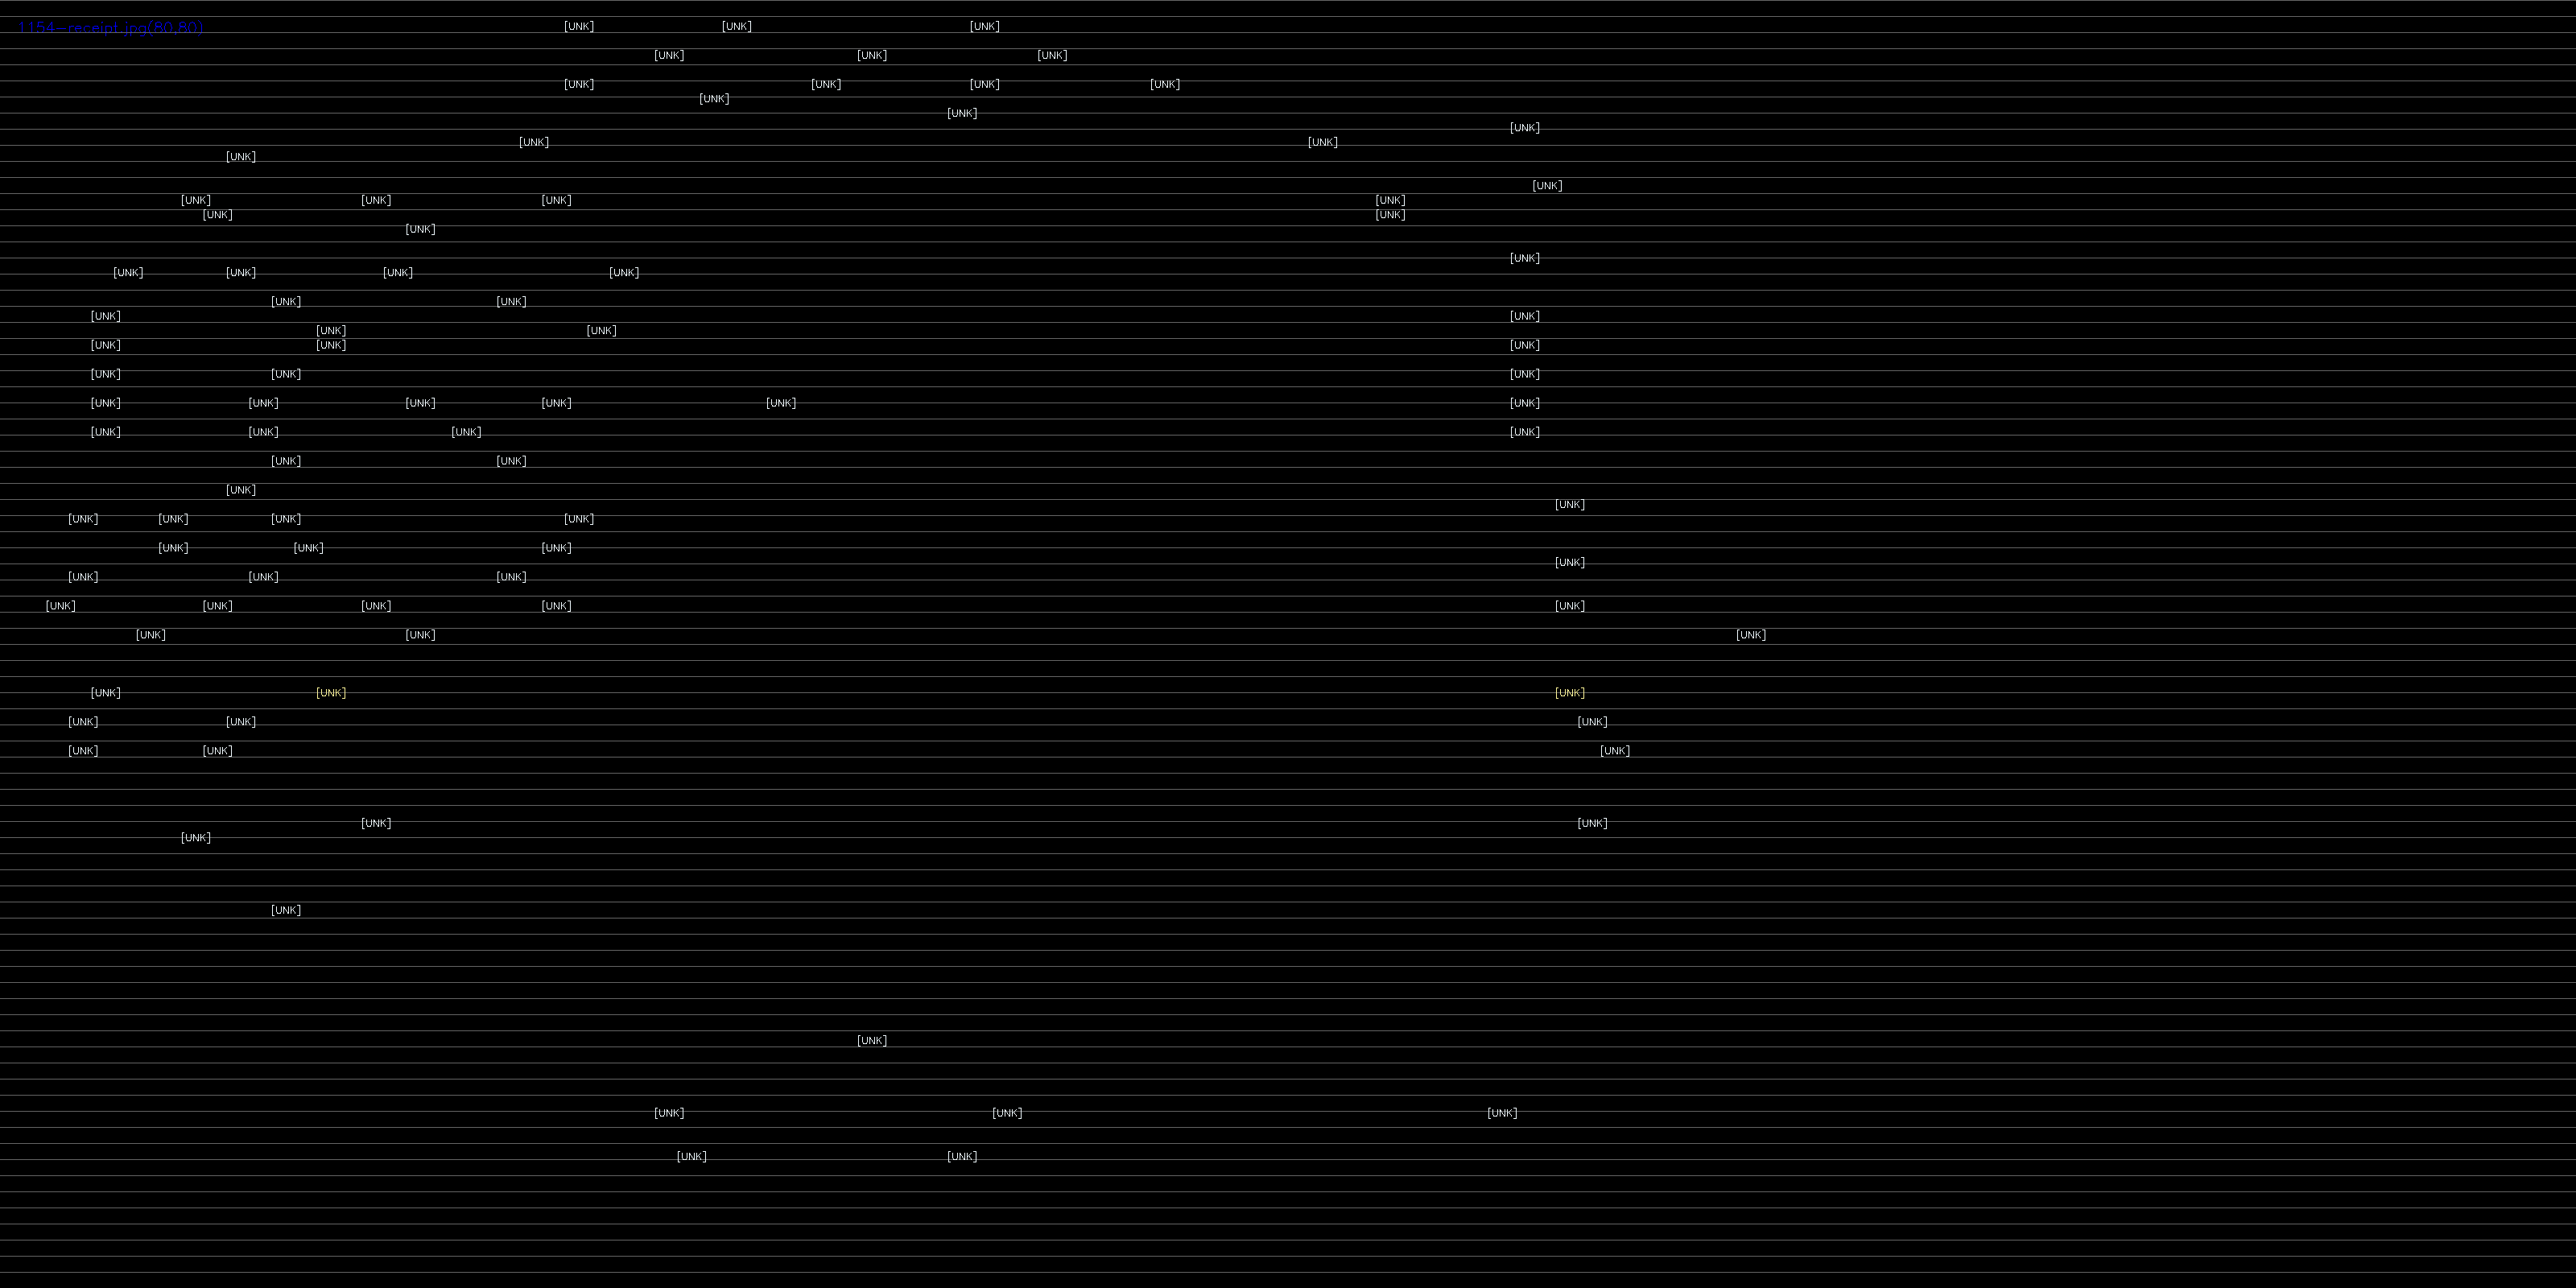

1 samples left to be tested
1154-receipt.jpg
(1, 80, 80, 1) (0,) (0,)
	 >>time per step: 2.62s <<
len(data_input_flat): 6400
indexes: [ 104  111  122  268  277  285  424  435  442  450  510  601  706  742
  777  809 1027 1047 1055 1063 1100 1128 1180 1217 1426 1444 1449 1456
 1466 1611 1621 1683 1746 1773 1785 1843 1853 1906 2003 2011 2066 2163
 2170 2177 2183 2193 2226 2323 2330 2339 2386 2491 2501 2649 2788 2802
 2806 2811 2824 2966 2972 2983 3108 3122 3130 3141 3281 3288 3295 3303
 3348 3445 3457 3516 3763 3773 3828 3922 3929 3989 4082 4088 4150 4495
 4549 4567 4971 5717 6108 6123 6145 6349 6361]

TTL(GT/Inf):	"[UNK] [UNK]" | "[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [U

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [12]:
# evaluation
ckpt_saver = tf.train.Saver()
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    try:
        ckpt_path = join(params.e_ckpt_path, params.save_prefix, params.ckpt_file)
        # ckpt_path = '/content/content/CUTIE/graph/INVOICE/CUTIE_atrousSPP_best.ckpt'
        ckpt = tf.train.get_checkpoint_state(ckpt_path)
        print('Restoring from {}...'.format(ckpt_path))
        ckpt_saver.restore(sess, ckpt_path)
        print('{} restored'.format(ckpt_path))
    except:
        raise Exception('Check your pretrained {:s}'.format(ckpt_path))
    
    # calculate validation accuracy and display results   
    recalls, accs_strict, accs_soft = [], [], []
    num_test = len(data_loader.validation_docs)
    for i in range(num_test):
        data = data_loader.fetch_validation_data()
        print('{:d} samples left to be tested'.format(num_test-i))
        
#             grid_table = data['grid_table']
#             gt_classes = data['gt_classes']
        feed_dict = {
            network.data_grid: data['grid_table'],
        }
        if params.use_cutie2:
            feed_dict = {
                network.data_grid: data['grid_table'],
                network.data_image: data['data_image'],
                network.ps_1d_indices: data['ps_1d_indices']
            }
        fetches = [model_output]
        
        print(data['file_name'][0])
        print(data['grid_table'].shape, data['data_image'].shape, data['ps_1d_indices'].shape)
        
        timer_start = timeit.default_timer()
        [model_output_val] = sess.run(fetches=fetches, feed_dict=feed_dict)
        timer_stop = timeit.default_timer()
        print('\t >>time per step: %.2fs <<'%(timer_stop - timer_start))
            
        if not params.is_table:
            recall, acc_strict, acc_soft, res = cal_accuracy(params.c_threshold, data_loader, np.array(data['grid_table']), 
                                                    np.array(data['gt_classes']), model_output_val, 
                                                    np.array(data['label_mapids']), data['bbox_mapids'])  
        else:
            recall, acc_strict, acc_soft, res = cal_accuracy_table(params.c_threshold, data_loader, np.array(data['grid_table']), 
                                                    np.array(data['gt_classes']), model_output_val, 
                                                    np.array(data['label_mapids']), data['bbox_mapids'])                     
#             recall, acc_strict, acc_soft, res = cal_save_results(data_loader, np.array(data['grid_table']), 
#                                                        np.array(data['gt_classes']), model_output_val, 
#                                                        np.array(data['label_mapids']), data['bbox_mapids'],
#                                                        data['file_name'][0], params.save_prefix)
        recalls += [recall]
        accs_strict += [acc_strict] 
        accs_soft += [acc_soft]
        if acc_strict != 1:
            print(res.decode()) # show res for current batch
        
        # visualize result
        shape = data['shape']
        file_name = data['file_name'][0] # use one single file_name
        bboxes = data['bboxes'][file_name]
        if not params.is_table:
            vis_bbox(data_loader, params.doc_path, np.array(data['grid_table'])[0], 
                      np.array(data['gt_classes'])[0], np.array(model_output_val)[0], file_name, 
                      np.array(bboxes), shape)
        else:
            vis_table(data_loader, params.doc_path, np.array(data['grid_table'])[0], 
                      np.array(data['gt_classes'])[0], np.array(model_output_val)[0], file_name, 
                      np.array(bboxes), shape)

    recall = sum(recalls) / len(recalls)
    acc_strict = sum(accs_strict) / len(accs_strict)
    acc_soft = sum(accs_soft) / len(accs_soft)
    print('EVALUATION ACC (Recall/Acc): %.3f / %.3f (%.3f) \n'%(recall, acc_strict, acc_soft))